# Autoregressive Strategy Simulator

This notebook modifies the reset strategy from the ```ResetStrategyImplementer.py``` to use a more complex statistical model to dynamically set the center and width of the liquidity provision ranges  depending on recent behavior of the market. For example, it will broaden the ranges when there have been recent large price movements, in order to ensure we are in range for longer, mitigating impermanent loss by reducing the concentration of liquidity. 

The statistical model embeds the concept of mean reversion, by allowing to forecast autoregressive term for the return, which shifts the center of the base and limit ranges in the direction that the model expects the price to go, hence the name ```AutoRegressiveStrategy```. This feature seeks to further increase the time spent in-range and mitigating impermanent loss.

The underlying model is a simple AR(1)-GARCH(1,1) model, which estimates the recent expected return and the volatility of the price based on recent observations. This new strategy is implemented in ```AutoRegressiveStrategyImplementer.py```.

Suppose that the price at time $t$ of the USDC-WETH 0.3% pool is $q_t$, then the price in USDC terms would be $p_t = 1/q_t$. The return is defined as $r_t = p_t / p_{t-1} - 1$, and this is the time series we model:

$$ r_t = c + \rho r_{t-1} + \sigma_t \varepsilon_t$$
$$ \sigma_t^2 = \omega + \alpha \varepsilon_{t-1} + \beta\sigma_{t-1}^2$$

For the strategy, we estimate the model only with the data that was available at that time, therefore making the simulations more realistic. Note that automatically setting bin width is part of the well-known Bollinger Bands strategy. Imposing a consistent statistical model gives more structure to the optimization problem, as well as allowing for forecasting and simulation more easily, which are part of our current plans.

In [2]:
import pandas as pd
import numpy as np
import GetPoolData
import AutoRegressiveStrategyImplementer
import itertools
import arch
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy

# Create config.py in this directory and enter your own Bitquery API Token
from config import BITQUERY_API_TOKEN

#################
#
# Download data
#
################

# Get Swap Data
DOWNLOAD_DATA      = False
address            = '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801'  
token_0_address    = '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984'
token_1_address    = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
usdc_address       =  '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
flipside_query     = ['https://api.flipsidecrypto.com/api/v2/queries/ac80e246-b0ba-4a2c-b785-8927c8f6668b/data/latest']

# Price data for theThese must be month ends
price_data_begin   = '2020-12-31'
price_data_end     = '2021-12-31'
file_name          = 'eth_uni'
file_name_usd      = 'usdc_uni'

swap_data          = GetPoolData.get_pool_data_flipside(address,flipside_query,file_name,DOWNLOAD_DATA)  
price_data         = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name,DOWNLOAD_DATA)
token_0_usd_data   = GetPoolData.get_price_data_bitquery(usdc_address,token_0_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name_usd,DOWNLOAD_DATA)

In [3]:
#################
#
# Run Auto Regressive Strategy
#
################

import importlib
importlib.reload(GetPoolData)
importlib.reload(AutoRegressiveStrategyImplementer)

# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-15 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-07-28 00:00PM',utc=True)

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY                 = 1 # (at least one minute)
simulate_data_filtered             = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered['z_scores'] = np.abs(scipy.stats.zscore(simulate_data_filtered['quotePrice']))
simulate_data_filtered             = simulate_data_filtered.drop(simulate_data_filtered[abs(simulate_data_filtered.z_scores) > 3].index)
simulate_data_filtered             = simulate_data_filtered.sort_index()
simulate_data_price                = simulate_data_filtered[DATE_BEGIN:DATE_END]['quotePrice']

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
AGGREGATED_MINUTES     = 60*24 
price_data_filtered    = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)

# USD Data remove outliers
token_0_usd_data['z_scores'] = np.abs(scipy.stats.zscore(token_0_usd_data['quotePrice']))
token_0_usd_data             = token_0_usd_data.drop(token_0_usd_data[abs(token_0_usd_data.z_scores) > 3].index)


# Initial Position Details
initial_usd_price          = 1/token_0_usd_data.iloc[abs(token_0_usd_data.index - DATE_BEGIN).argmin()]['quotePrice']
INITIAL_TOKEN_0            = 100000/initial_usd_price
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0*initial_usd_price
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 18
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*10**DECIMALS_1
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

# Strategy Parameters
alpha_range    = [3, 4, 5]
tau_range      = [3, 4, 5]
limit_range    = [.5,.5,.5]
vol_range      = [.5,.5,.5]

results        = []
results_data   = []

for j in zip(alpha_range,tau_range,limit_range,vol_range):
    print(j)
    simulated_strategy               = AutoRegressiveStrategyImplementer.run_autoreg_strategy(simulate_data_price,swap_data,price_data_filtered,j[0],j[1],j[2],j[3],INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)                                      
    data_strategy                    = pd.DataFrame([i.dict_components() for i in simulated_strategy])
    data_strategy                    = data_strategy.set_index('time',drop=False)
    data_strategy                    = data_strategy.sort_index()
    strat_result                     = AutoRegressiveStrategyImplementer.analyze_strategy(data_strategy,INITIAL_POSITION_VALUE,token_0_usd_data)
    strat_result['alpha_param']      = j[0]
    strat_result['tau_param']        = j[1]
    strat_result['limit_param']      = j[2]
    strat_result['volatility_param'] = j[3]
    results_data.append(simulated_strategy)
    results.append(strat_result)
    
    
pd.DataFrame(results)

(3, 3, 0.5, 0.5)
(4, 4, 0.5, 0.5)
(5, 5, 0.5, 0.5)


,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param,volatility_param
0,13,0.541522,0.019287,3.735425,0.133043,8,0.300126,1.651874,2.261325,0.747427,0.620743,3,3,0.5,0.5
1,13,0.369824,0.013172,3.932746,0.140070,0,0.299229,1.641101,2.396408,0.981412,0.981398,4,4,0.5,0.5
2,13,0.288933,0.010291,3.997913,0.142391,0,0.297800,1.652211,2.419734,0.987774,0.987781,5,5,0.5,0.5


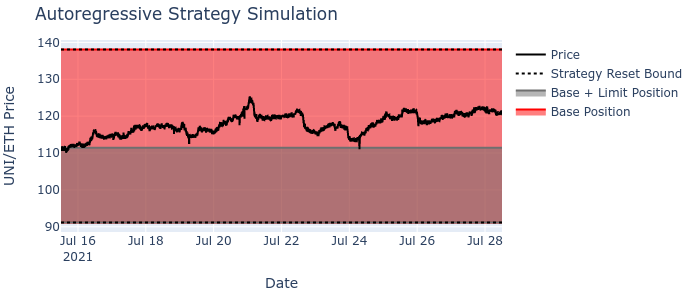

In [4]:
SELECTED_STRATEGY                         = 2
simulated_strategy                        = results_data[SELECTED_STRATEGY]
data_strategy_long                        = pd.DataFrame([i.dict_components() for i in simulated_strategy])
data_strategy_long                        = data_strategy_long.set_index('time',drop=False)
data_strategy_long                        = data_strategy_long.sort_index()
data_strategy_long['value_hold']          = INITIAL_TOKEN_0 + INITIAL_TOKEN_1 * data_strategy_long['price_1_0']
data_strategy_long['relative_to_holding'] = data_strategy_long['value_position']/data_strategy_long['value_hold']-1
data_strategy_long['net_gain']            = (data_strategy_long['value_position']  - INITIAL_POSITION_VALUE)/INITIAL_POSITION_VALUE
pd.DataFrame([AutoRegressiveStrategyImplementer.analyze_strategy(data_strategy_long,INITIAL_POSITION_VALUE)])

CHART_SIZE = 300

fig_strategy = go.Figure()
fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=1/data_strategy_long['base_range_lower'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#ff0000',
    ))
fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=1/data_strategy_long['base_range_upper'],
    name='Base Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#ff0000',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=1/data_strategy_long['limit_range_lower'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#6f6f6f'))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=1/data_strategy_long['limit_range_upper'],
    name='Base + Limit Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#6f6f6f',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=1/data_strategy_long['reset_range_lower'],
    name='Strategy Reset Bound',
    line=dict(width=2,dash='dot',color='black')))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=1/data_strategy_long['reset_range_upper'],
    showlegend = False,
    line=dict(width=2,dash='dot',color='black',)))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['price_1_0'],
    name='Price',
    line=dict(width=2,color='black')))

fig_strategy.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Autoregressive Strategy Simulation',
    xaxis_title="Date",
    yaxis_title="UNI/ETH Price",
)

fig_strategy.show(renderer="png")

# LONG PERIOD

In [37]:
# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-01 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-08-15 00:00PM',utc=True)

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY                 = 1 # (at least one minute)
simulate_data_filtered             = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered['z_scores'] = np.abs(scipy.stats.zscore(simulate_data_filtered['quotePrice']))
simulate_data_filtered             = simulate_data_filtered.drop(simulate_data_filtered[abs(simulate_data_filtered.z_scores) > 3].index)
simulate_data_filtered             = simulate_data_filtered.sort_index()
simulate_data_price                = simulate_data_filtered[DATE_BEGIN:DATE_END]['quotePrice']

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
AGGREGATED_MINUTES     = 60*24 
price_data_filtered    = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)

# USD Data remove outliers
token_0_usd_data['z_scores'] = np.abs(scipy.stats.zscore(token_0_usd_data['quotePrice']))
token_0_usd_data             = token_0_usd_data.drop(token_0_usd_data[abs(token_0_usd_data.z_scores) > 3].index)


# Initial Position Details
initial_usd_price          = 1/token_0_usd_data.iloc[abs(token_0_usd_data.index - DATE_BEGIN).argmin()]['quotePrice']
INITIAL_TOKEN_0            = 100000/initial_usd_price
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0*initial_usd_price
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 18
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*10**DECIMALS_1
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

# Strategy Parameters
alpha_range    = [3,4,6]
tau_range      = [3,4,5]
limit_range    = [.1,.5,.7]
vol_range      = [.5]

results        = []
results_data   = []

for j in list(itertools.product(alpha_range,tau_range,limit_range,vol_range)):
    print(j)
    simulated_strategy               = AutoRegressiveStrategyImplementer.run_autoreg_strategy(simulate_data_price,swap_data,price_data_filtered,j[0],j[1],j[2],j[3],INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)                                      
    data_strategy                    = pd.DataFrame([i.dict_components() for i in simulated_strategy])
    data_strategy                    = data_strategy.set_index('time',drop=False)
    data_strategy                    = data_strategy.sort_index()
    strat_result                     = AutoRegressiveStrategyImplementer.analyze_strategy(data_strategy,INITIAL_POSITION_VALUE,token_0_usd_data)
    strat_result['alpha_param']      = j[0]
    strat_result['tau_param']        = j[1]
    strat_result['limit_param']      = j[2]
    strat_result['volatility_param'] = j[3]
    results_data.append(simulated_strategy)
    results.append(strat_result)
    
    
pd.DataFrame(results)

(3, 3, 0.1, 0.5)
(3, 3, 0.5, 0.5)
(3, 3, 0.7, 0.5)
(3, 4, 0.1, 0.5)
(3, 4, 0.5, 0.5)
(3, 4, 0.7, 0.5)
(3, 5, 0.1, 0.5)
(3, 5, 0.5, 0.5)
(3, 5, 0.7, 0.5)
(4, 3, 0.1, 0.5)
(4, 3, 0.5, 0.5)
(4, 3, 0.7, 0.5)
(4, 4, 0.1, 0.5)
(4, 4, 0.5, 0.5)
(4, 4, 0.7, 0.5)
(4, 5, 0.1, 0.5)
(4, 5, 0.5, 0.5)
(4, 5, 0.7, 0.5)
(6, 3, 0.1, 0.5)
(6, 3, 0.5, 0.5)
(6, 3, 0.7, 0.5)
(6, 4, 0.1, 0.5)
(6, 4, 0.5, 0.5)
(6, 4, 0.7, 0.5)
(6, 5, 0.1, 0.5)
(6, 5, 0.5, 0.5)
(6, 5, 0.7, 0.5)


,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param,volatility_param
0,45,0.555926,0.068539,4.104940,0.506089,14,0.630708,6.476233,0.633847,0.621597,0.717193,3,3,0.1,0.5
1,45,0.602156,0.074238,4.058874,0.500409,13,0.630399,6.481636,0.626211,0.586803,0.612912,3,3,0.5,0.5
2,45,0.554740,0.068393,4.134269,0.509704,4,0.626732,6.477327,0.638268,0.606421,0.662033,3,3,0.7,0.5
3,45,0.569959,0.070269,4.153105,0.512027,0,0.619718,6.494516,0.639479,0.957869,0.957863,3,4,0.1,0.5
4,45,0.569959,0.070269,4.153105,0.512027,0,0.619718,6.494516,0.639479,0.957869,0.957863,3,4,0.5,0.5
5,45,0.569959,0.070269,4.153105,0.512027,0,0.619718,6.494516,0.639479,0.957869,0.957863,3,4,0.7,0.5
6,45,0.569959,0.070269,4.153105,0.512027,0,0.619718,6.494516,0.639479,0.957869,0.957863,3,5,0.1,0.5
7,45,0.569959,0.070269,4.153105,0.512027,0,0.619718,6.494516,0.639479,0.957869,0.957863,3,5,0.5,0.5
8,45,0.569959,0.070269,4.153105,0.512027,0,0.619718,6.494516,0.639479,0.957869,0.957863,3,5,0.7,0.5
9,45,0.478099,0.058944,4.158597,0.512704,9,0.624946,6.476428,0.642113,0.643086,0.709664,4,3,0.1,0.5


In [33]:
pd.DataFrame(results)

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param,volatility_param
0,45,0.478099,0.058944,4.158597,0.512704,9,0.624946,6.476428,0.642113,0.643086,0.709664,4,3,0.1,0.5
1,45,0.464794,0.057303,4.099156,0.505375,10,0.629975,6.467684,0.633790,0.614798,0.664863,4,3,0.1,0.9
2,45,0.575814,0.070991,4.034491,0.497403,10,0.624169,6.480052,0.622602,0.640795,0.610101,4,3,0.5,0.5
3,45,0.513504,0.063309,3.985617,0.491377,13,0.630238,6.471975,0.615827,0.604803,0.642627,4,3,0.5,0.9
4,45,0.476239,0.058714,4.176189,0.514873,0,0.619147,6.485948,0.643883,0.937729,0.937802,4,5,0.1,0.5
5,45,0.476340,0.058727,4.176189,0.514873,1,0.619147,6.485948,0.643883,0.943845,0.938559,4,5,0.1,0.9
6,45,0.476239,0.058714,4.176189,0.514873,0,0.619147,6.485948,0.643883,0.937729,0.937802,4,5,0.5,0.5
7,45,0.476340,0.058727,4.176189,0.514873,1,0.619147,6.485948,0.643883,0.943845,0.938559,4,5,0.5,0.9
8,45,0.361479,0.044566,4.160340,0.512919,4,0.618600,6.479063,0.642121,0.757660,0.751679,6,3,0.1,0.5
9,45,0.316825,0.039061,4.172137,0.514373,5,0.623120,6.469165,0.644927,0.743043,0.791824,6,3,0.1,0.9


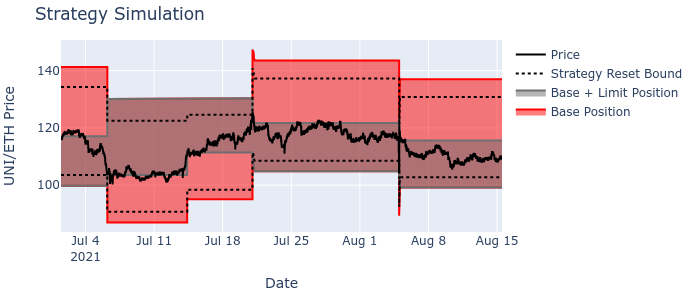

In [36]:
SELECTED_STRATEGY                    = 2
resulting_strat                      = results_data[SELECTED_STRATEGY]
data_strategy                        = pd.DataFrame([i.dict_components() for i in resulting_strat])
data_strategy                        = data_strategy.set_index('time',drop=False)
data_strategy                        = data_strategy.sort_index()




CHART_SIZE = 300

fig_strategy = go.Figure()
fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=1/data_strategy['base_range_lower'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#ff0000',
    ))
fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=1/data_strategy['base_range_upper'],
    name='Base Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#ff0000',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=1/data_strategy['limit_range_lower'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#6f6f6f'))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=1/data_strategy['limit_range_upper'],
    name='Base + Limit Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#6f6f6f',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=1/data_strategy['reset_range_lower'],
    name='Strategy Reset Bound',
    line=dict(width=2,dash='dot',color='black')))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=1/data_strategy['reset_range_upper'],
    showlegend = False,
    line=dict(width=2,dash='dot',color='black',)))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['price_1_0'],
    name='Price',
    line=dict(width=2,color='black')))

fig_strategy.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Strategy Simulation',
    xaxis_title="Date",
    yaxis_title="UNI/ETH Price",
)

fig_strategy.show(renderer="png")